# Seq2Seq

Seq2Seq model is the learning of sequence text as input and sequence text in output. Note that the length of the input and output must not be the same. A typical sequence to sequence model consiste of encoder and decoder which are themselves two separate neural networks combined into a single giant network. Both encoder and decoder are typically LSTM or GRU models.
Some applications of Seq2Seq models are Neural machine translation, Image captioning, speech recognition, chat-bot, time-series forecasting e.t.c.

# Machine Translation using seq2seq with Attention Impletmentation
In this project we are going to learn seq2seq with which we implement attention mechanism for better result. The problem with typical seq2seq model which has only encoder and decoder is that it is not better for long sentences and there are some issue with performance also. That why we add attention mechanism for better performance and fast training.
Steps:
1) Loading Data
2) Preprocessing
3) Tokenization
4) Padding
5) Train Test Splitting
4) Encoder
7) Bahdanau Attention
8) Decoder
9) Traing
10) Inference
11) Evaluation

# Loading Data
we use french to english dataset for this project. We download this dataset from http://www.manythings.org/anki/.
In this dataset every line is the paire of first english and then france sentence. We convert english and french sentence separately we do data cleaning.

In [1]:
import pandas as pd
import numpy as np
import io

file_path = '/content/fra.txt'

pairs = []

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        parts = line.split('\t')

        if len(parts) >= 2:
            english = parts[0].strip()
            french = parts[1].strip()
            pairs.append((english, french))

print("Total sentence pairs loaded:", len(pairs))

Total sentence pairs loaded: 239189


In [2]:
print(f"English: {pairs[0][0]}")
print(f"French: {pairs[0][1]}")

English: Go.
French: Va !


Now we done with data loading lets move to data preprocessing which is neccessary for every nlp task. Becuase model does not know text. It knows only number so first we do data cleaning we remove some extra words or tokens which are not neccessary for our model

In [3]:
import re
import unicodedata

def unicode_to_ascii(s):
  """convert special french character like é, è, ê to normal form."""
  return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [4]:
def clean_text(s):
  s = s.lower().strip()
  s = unicode_to_ascii(s) # normalize unicode
  s = re.sub(r"([?.!,¿])", r" \1 ", s) # separate punctuation
  s = re.sub(r'\s+', ' ', s) # remove extra spaces
  s = re.sub(r"[^a-zA-Z?.!,¿']+", " ", s) # need only letters number and some other punctuation
  return s.strip()

In [5]:
clean_pairs = []
for eng, fr in pairs:
    eng_clean = clean_text(eng)
    fr_clean = clean_text(fr)
    eng_clean = '<start> ' + eng_clean + ' <end>'  # we add some spatial word start and end in the fre_clean data
    clean_pairs.append((eng_clean, fr_clean))

In [6]:
for i in range(5):
  print(f"English: {clean_pairs[i][0]}")
  print(f"French: {clean_pairs[i][1]}")

English: <start> go . <end>
French: va !
English: <start> go . <end>
French: marche .
English: <start> go . <end>
French: en route !
English: <start> go . <end>
French: bouge !
English: <start> hi . <end>
French: salut !


In [7]:
all_eng_words = set()
for en, fr in clean_pairs:
    for word in en.split():
        all_eng_words.add(word)

print("Unique English words:", len(all_eng_words))

Unique English words: 16850


Now we done with some preprocessing but some are still exist now  we tokenized our data by some length of unique words. mean we add top unique words and remaining we adACd to unk. Mean in our test if words is out of vocabulary it assign it to unk if add all length of unique words our training time and memore time will increased.
Instead of using 16000 we only use 10000 and rest of words are goes to unk.

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

eng_sentences = [eng for eng,fre in clean_pairs]
fre_sentences = [fre for eng,fre in clean_pairs]


num_words_src = 20000   # English words limit
num_words_tgt = 10000   # French words limit

eng_tokenizer = Tokenizer(num_words = num_words_tgt, filters = "", oov_token = '<unk>')
eng_tokenizer.fit_on_texts(eng_sentences)

fr_tokenizer = Tokenizer(num_words = num_words_src,filters = "",oov_token = '<unk>')
fr_tokenizer.fit_on_texts(fre_sentences)



In [9]:
print("English vocabulary size:", len(eng_tokenizer.word_index))
print("French vocabulary size:", len(fr_tokenizer.word_index))

English vocabulary size: 16851
French vocabulary size: 29456


In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

eng_sequences = eng_tokenizer.texts_to_sequences([eng for eng,fre in clean_pairs])
fre_sequences = fr_tokenizer.texts_to_sequences([fre for eng,fre in clean_pairs])

max_eng_len = max(len(seq) for seq in eng_sequences)
max_fr_len = max(len(seq) for seq in fre_sequences)

eng_padded = pad_sequences(eng_sequences, maxlen=max_eng_len, padding='post')
fr_padded = pad_sequences(fre_sequences, maxlen=max_fr_len, padding='post')


In [11]:
max_eng_len

68

In [12]:
print("English padded shape:", eng_padded.shape)
print("French padded shape:", fr_padded.shape)

English padded shape: (239189, 68)
French padded shape: (239189, 69)


In [13]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

y = eng_padded
X = fr_padded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training y data", y_train.shape)
print("Testing y data", y_test.shape)

BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

print("✅ TensorFlow datasets created successfully!")


Training data shape: (191351, 69)
Testing data shape: (47838, 69)
Training y data (191351, 68)
Testing y data (47838, 68)
✅ TensorFlow datasets created successfully!


# Encoder


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.enc_units = enc_units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(self.enc_units,return_sequences = True,return_state = True,recurrent_initializer='glorot_uniform')
  def call(self,x,hidden):
    x = self.embedding(x)
    output,state_h,state_c = self.lstm(x,initial_state = hidden)
    return output,state_h,state_c
  def initial_hidden_state(self):
    return (tf.zeros((self.batch_size, self.enc_units)),
                tf.zeros((self.batch_size, self.enc_units)))


# Attention

In [15]:
from tensorflow.keras.layers import Layer

class BahdanauAttention(tf.keras.Model):
  def __init__(self,units):
    super(BahdanauAttention,self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)
  def call(self,encoder_outputs,decoder_hidden):
    decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
    score = self.V(tf.nn.tanh(self.W1(encoder_outputs)+self.W2(decoder_hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score,axis = 1)
    context_vector = attention_weights * encoder_outputs
    context_vector = tf.reduce_sum(context_vector,axis = 1)
    return context_vector, tf.squeeze(attention_weights,axis = -1)

# Decoder

In [31]:
class Decoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,dec_units,batch_size):
    super(Decoder,self).__init__()
    self.batch_size = batch_size
    self.enc_units = dec_units
    self.embedding = Embedding(vocab_size,embedding_dim)
    self.lstm = LSTM(self.enc_units,return_sequences = True,return_state = True,recurrent_initializer = 'glorot_uniform')
    self.fc = Dense(vocab_size)
    self.attention = BahdanauAttention(self.enc_units)
  def call(self,x,hidden,encoder_outputs):
    if isinstance(hidden, tuple):
        hidden = hidden[0]
    context_vector,attention_weights = self.attention(encoder_outputs,hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector,1),x],axis = -1)
    output,state_h,state_c = self.lstm(x)
    output = tf.reshape(output,(-1,output.shape[2]))
    x = self.fc(output)
    return x,(state_h,state_c),attention_weights

In [32]:
BUFFER_SIZE = X_train.shape[0]
BATCH_SIZE = 64
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(fr_tokenizer.word_index) + 1
vocab_tar_size = len(eng_tokenizer.word_index) + 1

# Create Encoder and Decoder objects
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)


In [33]:
vocab_inp_size

29457

In [34]:
vocab_tar_size

16852

In [35]:
# Define optimizer and loss
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # ignore padding
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

# Why Masking
If we do not do masking, model try to predict padded token that why training become slow and inaccurate.
loss artificially become so high.

With Masking model focuss only on meaningful tokens
convergence become faster and translation quality improves

In [36]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        # Encoder pass
        enc_output, enc_h, enc_c = encoder(inp, enc_hidden)

        dec_hidden = (enc_h,enc_c)

        # Decoder input starts with <start> token
        dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing: feeding the target as next input
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)

            # use true label (teacher forcing)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = loss / int(targ.shape[1])

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    enc_hidden = encoder.initial_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(train_ds.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')

    # Average loss per epoch
    print(f'Epoch {epoch+1} Loss {total_loss / steps_per_epoch:.4f}\n')


Epoch 1 Batch 0 Loss 0.1356
Epoch 1 Batch 100 Loss 0.1735
Epoch 1 Batch 200 Loss 0.1681
Epoch 1 Batch 300 Loss 0.1461
Epoch 1 Batch 400 Loss 0.1727
Epoch 1 Batch 500 Loss 0.1094
Epoch 1 Batch 600 Loss 0.1597
Epoch 1 Batch 700 Loss 0.1360
Epoch 1 Batch 800 Loss 0.1520
Epoch 1 Batch 900 Loss 0.1436
Epoch 1 Batch 1000 Loss 0.1220
Epoch 1 Batch 1100 Loss 0.1437
Epoch 1 Batch 1200 Loss 0.1362
Epoch 1 Batch 1300 Loss 0.1458
Epoch 1 Batch 1400 Loss 0.1655
Epoch 1 Batch 1500 Loss 0.1286
Epoch 1 Batch 1600 Loss 0.1188
Epoch 1 Batch 1700 Loss 0.1691
Epoch 1 Batch 1800 Loss 0.1751
Epoch 1 Batch 1900 Loss 0.1311
Epoch 1 Batch 2000 Loss 0.1386
Epoch 1 Batch 2100 Loss 0.1349
Epoch 1 Batch 2200 Loss 0.1284
Epoch 1 Batch 2300 Loss 0.0903
Epoch 1 Batch 2400 Loss 0.1210
Epoch 1 Batch 2500 Loss 0.1174
Epoch 1 Batch 2600 Loss 0.1091
Epoch 1 Batch 2700 Loss 0.1280
Epoch 1 Batch 2800 Loss 0.1007
Epoch 1 Batch 2900 Loss 0.1085
Epoch 1 Loss 0.1335

Epoch 2 Batch 0 Loss 0.1050
Epoch 2 Batch 100 Loss 0.1088
Epo

In [108]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


In [109]:
def evaluate(sentence):
    attention_plot = np.zeros((max_eng_len, max_fr_len))

    # Preprocess the input sentence (same as training)
    sentence = preprocess_sentence(sentence)

    inputs = [fr_tokenizer.word_index.get(i, fr_tokenizer.word_index['<unk>']) for i in sentence.split(' ')]
    inputs = pad_sequences([inputs], maxlen=max_fr_len, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = (tf.zeros((1, units)), tf.zeros((1, units)))
    enc_out, enc_h, enc_c = encoder(inputs, hidden)

    dec_hidden = (enc_h, enc_c)
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(max_eng_len):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # store attention weights for visualization
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        # get predicted word
        predicted_word = eng_tokenizer.index_word.get(predicted_id, '<unk>')


        # if end token predicted → stop translation
        if predicted_word == '<end>':
            return result.strip(), sentence, attention_plot
        result += predicted_word + ' '
        # predicted word becomes next input
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot


In [110]:
french_sentence = "Tu ferais mieux de me dire exactement ce qu’il s’est passé."
result = evaluate(french_sentence)
print(result[0])

you'd better tell me exactly what happened .


In [111]:
def plot_attention(attention, sentence, predicted_sentence):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    attention = attention[:len(predicted_sentence), :len(sentence)]

    cax = ax.matshow(attention, cmap='viridis')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + sentence, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()


/tmp/ipython-input-1914731185.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, rotation=90)
/tmp/ipython-input-1914731185.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence)


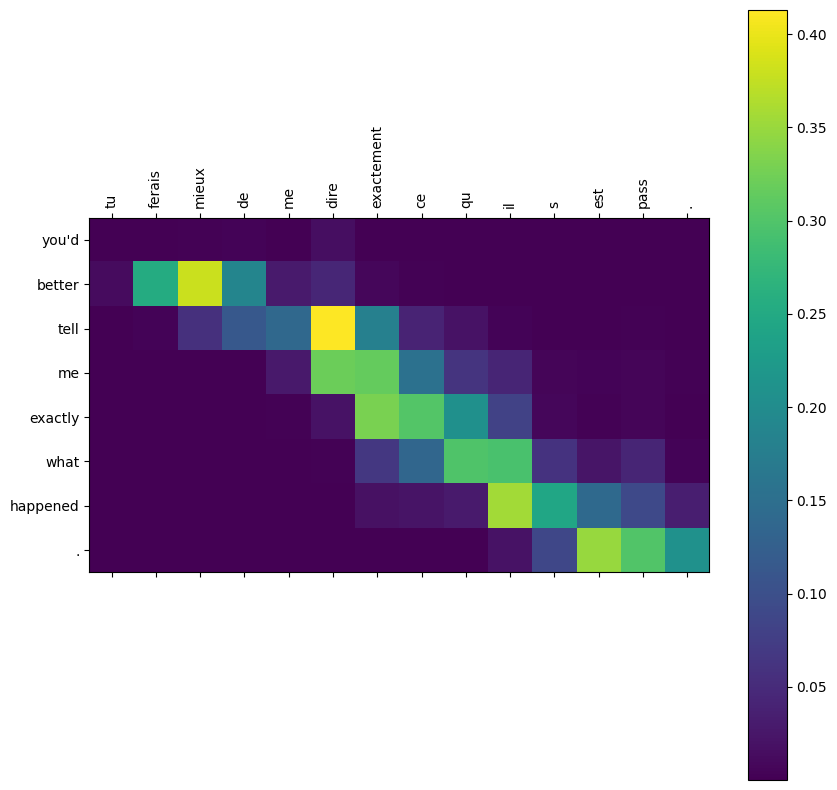

In [112]:
result, sentence, attention_plot = evaluate(french_sentence)
plot_attention(attention_plot, sentence.split(' '), result.split(" "))

In [113]:
from nltk.translate.bleu_score import sentence_bleu

reference = [['I', 'am', 'going', 'home']]
candidate = ['I', 'am', 'going', 'to', 'home']

score = sentence_bleu(reference, candidate)
print(score)

7.380245217279165e-78


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [87]:
from nltk.translate.bleu_score import corpus_bleu

references = [
    [['I', 'am', 'going', 'home']],
    [['He', 'is', 'sleeping']]
]
candidates = [
    ['I', 'am', 'going', 'home'],
    ['He', 'sleeping']
]

score = corpus_bleu(references, candidates)
print(score)

0.5985529678206387


In [98]:
test_sentences = [
    "je suis fatigué .",
    "il fait chaud aujourd'hui .",
    "j'aime le football ."
]

for sent in test_sentences:
    predicted, _, _ = evaluate(sent)
    print(f"\nInput: {sent}")
    print(f"Predicted: {predicted}")

    # prepare reference and candidate tokens
    reference = [sent.split()]  # human (French)
    candidate = predicted.lower().replace('.', '').split()  # model (English)

    bleu = sentence_bleu(reference, candidate)
    print(f"BLEU Score: {bleu:.4f}")



Input: je suis fatigué .
Predicted: i'm tired .
BLEU Score: 0.0000

Input: il fait chaud aujourd'hui .
Predicted: it's cold today .
BLEU Score: 0.0000

Input: j'aime le football .
Predicted: i like soccer .
BLEU Score: 0.0000


In [99]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

smooth_fn = SmoothingFunction().method1

def evaluate_bleu_on_test(test_ds, num_samples=100):
    total_bleu = 0
    count = 0

    for batch, (inp, targ) in enumerate(test_ds.take(num_samples)):
        # Convert tensor to numpy/int32
        inp = inp.numpy()
        targ = targ.numpy()

        # For each sentence in batch
        for i in range(inp.shape[0]):
            # Convert input tensor back to French sentence
            inp_sentence = ' '.join([fr_tokenizer.index_word.get(idx, '') for idx in inp[i] if idx != 0])

            # Convert target tensor back to English reference
            reference = [eng_tokenizer.index_word.get(idx, '') for idx in targ[i] if idx not in [0]]
            reference = [w for w in reference if w not in ['<start>', '<end>']]  # remove special tokens
            reference = [reference]  # wrap inside a list (required by nltk)

            # Predict translation using your model
            prediction, _, _ = evaluate(inp_sentence)
            candidate = prediction.lower().split()

            # Calculate BLEU score
            bleu = sentence_bleu(reference, candidate, smoothing_function=smooth_fn)
            total_bleu += bleu
            count += 1

        # Stop after num_samples sentences
        if count >= num_samples:
            break

    avg_bleu = total_bleu / count
    print(f"\nAverage BLEU score over {count} samples: {avg_bleu:.4f}")
    return avg_bleu


In [100]:
avg_bleu = evaluate_bleu_on_test(test_ds, num_samples=100)
print("Final BLEU Score:", avg_bleu)


Average BLEU score over 128 samples: 0.3563
Final BLEU Score: 0.3562729781195307
